In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics import tsaplots

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

2023-12-10 00:14:45.530549: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 00:14:45.550143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 00:14:45.550187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 00:14:45.550201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 00:14:45.554338: I tensorflow/core/platform/cpu_feature_g

In [2]:
#Получаем данные и удаляем лишние признаки
df = pd.read_csv('sber_day.csv', index_col='begin', parse_dates=True)
df = df.drop(['end', 'value', 'volume'], axis=1)
df

,open,close,high,low
begin,,,,
2022-01-03,295.90,305.47,305.50,294.34
2022-01-04,305.51,304.24,310.10,301.63
2022-01-05,303.72,287.01,304.26,287.00
2022-01-06,286.60,293.92,295.10,281.00
2022-01-10,295.52,291.69,298.88,288.68
...,...,...,...,...
2023-11-27,287.40,282.33,289.00,278.88
2023-11-28,282.40,279.91,282.51,277.32
2023-11-29,279.36,276.80,280.56,276.20


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 468 entries, 2022-01-03 to 2023-12-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    468 non-null    float64
 1   close   468 non-null    float64
 2   high    468 non-null    float64
 3   low     468 non-null    float64
dtypes: float64(4)
memory usage: 18.3 KB


In [4]:
#чек на монотонный рост
df.index.is_monotonic_increasing

True

In [5]:
print(f"{df.shape[0]} дней от {df.index.min()} to {df.index.max()}")

468 дней от 2022-01-03 00:00:00 to 2023-12-01 00:00:00


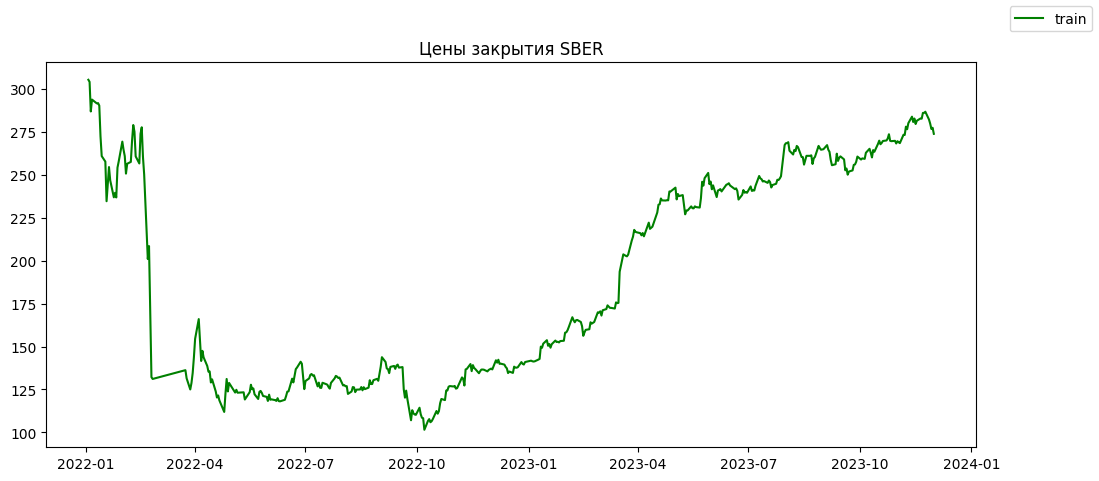

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])
ax.plot(df[['close']], c='green', label='train')
fig.legend()
plt.title('Цены закрытия SBER')
plt.show()

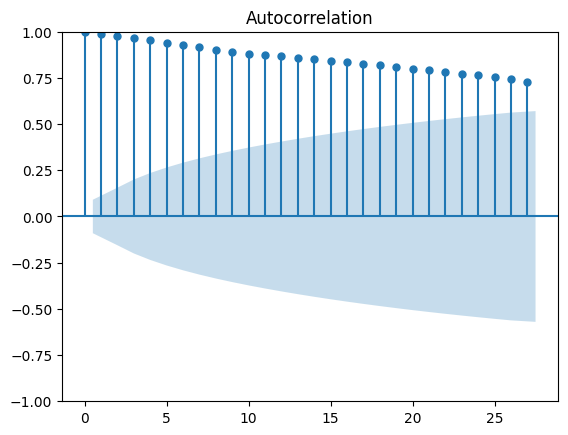

In [7]:
fig = tsaplots.plot_acf(df['close'])
plt.show()

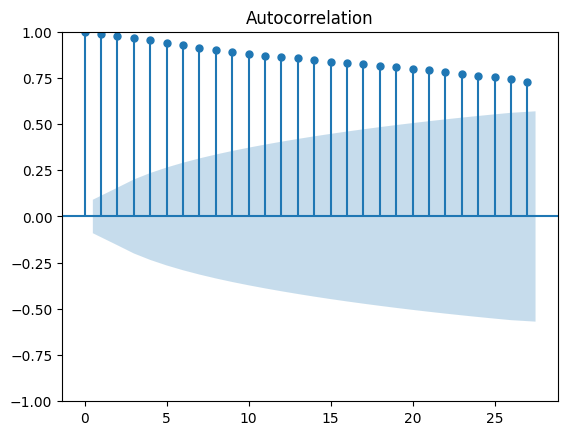

In [8]:
fig = tsaplots.plot_acf(df['open'])
plt.show()

In [9]:
#делим выборку на трейн и тест
df_train = df.iloc[170:402]
df_test = df.iloc[402:-1]
df_train

,open,close,high,low
begin,,,,
2022-10-03,110.62,114.35,114.65,109.00
2022-10-04,115.06,110.55,115.50,110.30
2022-10-05,110.49,108.51,110.49,106.25
2022-10-06,108.65,108.24,110.38,107.57
2022-10-07,107.70,101.50,108.48,101.30
...,...,...,...,...
2023-08-25,258.80,260.50,261.60,257.61
2023-08-28,261.32,266.93,267.83,260.81
2023-08-29,266.70,265.68,267.56,265.14


In [10]:
#делает признаки для предсказания и обучения
def make_features(data, column_list, lags_list, shift_list):

    data = data.copy()
    data['month'] = data.index.month
    data['min_max_diff'] = data.high - data.low
    data['open_close_diff'] = data.open - data.low
    data['weekday'] = data.index.map(lambda x: x.weekday())
    column_list = column_list + ['min_max_diff', 'open_close_diff']

    for col in column_list:
        for lag in lags_list:
            data[f'{col}_lag_{lag}'] = data[col].shift(lag)

        for i in shift_list:
            data[f'{col}_rolling_mean_{i}'] = data[col].rolling(i).mean().shift(i)

    return data

In [11]:
#модель простой полносвязной нейросети
def nn_model(features_train):
    model = Sequential()
    #полносвязные слои с нормализацией
    model.add(Dense(512, activation='relu', input_dim=features_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(512))
    model.add(Dense(512, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(256, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(256))
    model.add(Dense(128, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(128))
    model.add(Dense(128, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'))
    
    model.add(Dense(64))
    model.add(Dense(64))

    # Добавляем выходной слой
    model.add(Dense(4))

    # Компилируем модель с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer='adam', loss='mse')
    return model


In [12]:
#функция для обучения модели на 10 дней
def refit_model(df, lags_list, shift_list, ind_current):
    df_train = df.copy()
    df_train = pd.concat([df_train, pd.DataFrame(index=ind_current)])
    df_train = make_features(
        df_train, 
        ['open', 'close', 'high', 'low'], 
        lags_list, 
        shift_list
        )
    #отделяем трейн и тест
    df_train = df_train.iloc[max(lags_list):]
    df_train = df_train.fillna(0)
    df_test_2 = df_train.iloc[-len(ind_current):]
    df_train = df_train.iloc[:-len(ind_current)]
 
    features_train = df_train.drop(
        ['open', 'close', 'high', 'low', 'min_max_diff', 'open_close_diff'], 
        axis=1
        )
    target_train = df_train[['open', 'close', 'high', 'low']]
    features_test = df_test_2.drop(
        ['open', 'close', 'high', 'low', 'min_max_diff', 'open_close_diff'],
        axis=1
        )
    target_test = df_test[['open', 'close', 'high', 'low']]
    #нормализуем данные
    scaler = StandardScaler()
    features_train_scaler = scaler.fit_transform(features_train)
    features_test_scaler = scaler.transform(features_test)
    #моедль и обучение моделей
    model = nn_model(features_train)
    model.fit(
        features_train_scaler, 
        target_train,
        epochs=200,
        validation_split=0.2,
        batch_size=100)
    #предсказание модели
    prediction = pd.DataFrame(model.predict(features_test_scaler), columns=['open', 'close', 'high', 'low'])
    prediction.index = features_test.index  

    return pd.concat([df, prediction])
    

In [13]:
#параметры для фичи генерации
lags_list = [10, 11, 13, 15, 21]
shift_list = [10, 12, 15, 17]
max(lags_list)

21

In [14]:
%%time
#С шагом в 10 дней в цикле обучем модели
for i in range(0, len(df_test.index), 10):
    ind = df_test.index[i: i + 10]
    df_train = refit_model(df_train, lags_list, shift_list, ind)

df_train


Epoch 1/200


2023-12-10 00:14:46.873777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 00:14:46.876682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 00:14:46.876722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 00:14:46.878387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 00:14:46.878425: I tensorflow/compile

2/2 [==============================] - 3s 151ms/step - loss: 36242.3750 - val_loss: 65217.8672
Epoch 2/200
2/2 [==============================] - 0s 26ms/step - loss: 35724.0703 - val_loss: 64543.2539
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 35009.0430 - val_loss: 62819.4727
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 33950.5000 - val_loss: 58958.7891
Epoch 5/200
2/2 [==============================] - 0s 30ms/step - loss: 32363.8086 - val_loss: 52114.8477
Epoch 6/200
2/2 [==============================] - 0s 27ms/step - loss: 30107.1934 - val_loss: 43118.8672
Epoch 7/200
2/2 [==============================] - 0s 27ms/step - loss: 26986.8359 - val_loss: 34582.0078
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 23254.4961 - val_loss: 22136.9961
Epoch 9/200
2/2 [==============================] - 0s 27ms/step - loss: 18092.6016 - val_loss: 6734.4707
Epoch 10/200
2/2 [==============================] - 0s 28m

,open,close,high,low
begin,,,,
2022-10-03,110.620000,114.350000,114.650000,109.000000
2022-10-04,115.060000,110.550000,115.500000,110.300000
2022-10-05,110.490000,108.510000,110.490000,106.250000
2022-10-06,108.650000,108.240000,110.380000,107.570000
2022-10-07,107.700000,101.500000,108.480000,101.300000
...,...,...,...,...
2023-11-24,262.347687,260.680420,263.889923,259.219818
2023-11-27,264.202148,262.312775,265.717224,261.019012
2023-11-28,264.365784,262.459717,265.876221,261.182709


In [15]:
#отделяем предсказаний
prediction =  df_train.iloc[232:]
prediction

,open,close,high,low
begin,,,,
2023-09-01,254.037750,254.933441,256.859863,251.476761
2023-09-04,252.975342,253.750961,255.674240,250.416901
2023-09-05,250.528900,251.281677,253.187424,247.995453
2023-09-06,251.249954,252.022736,253.920868,248.718216
2023-09-07,254.117401,254.953003,256.875061,251.543655
...,...,...,...,...
2023-11-24,262.347687,260.680420,263.889923,259.219818
2023-11-27,264.202148,262.312775,265.717224,261.019012
2023-11-28,264.365784,262.459717,265.876221,261.182709


In [16]:
print("MAE тестовой выборки: ", mean_absolute_error(df_test, prediction))

MAE тестовой выборки:  8.486355971116286


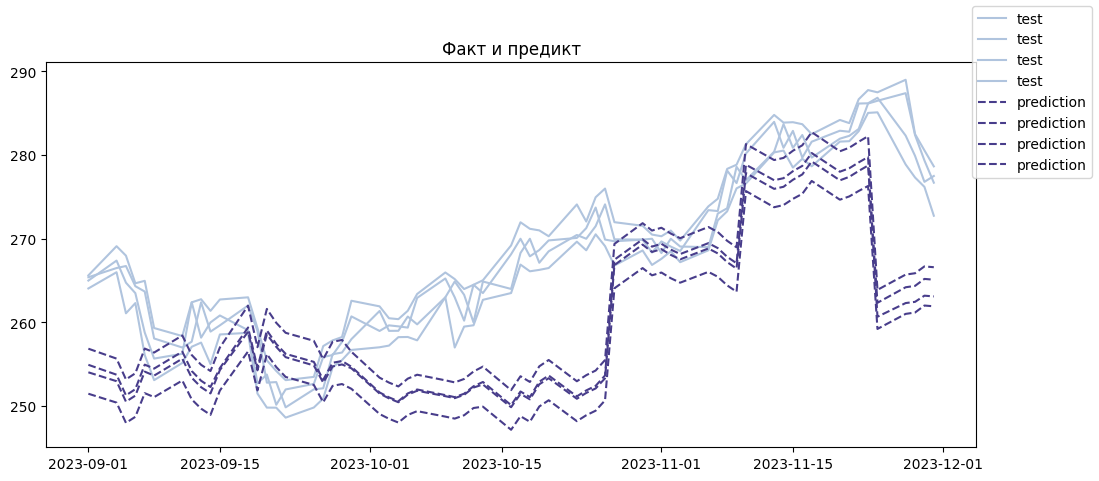

In [17]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])
ax.plot(df_test, c='lightsteelblue', label='test')
ax.plot(prediction, c='darkslateblue', label='prediction', linestyle='--')
plt.title('Факт и предикт')
fig.legend()
plt.show()